In [1]:
import pandas as pd
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
import numpy as np

import sys
import os
sys.path.append(os.path.join(os.getcwd(), '/home/jabez/Documents/week_9/Crypto-Trading-Engineering/scripts'))
import forecast

/home/jabez/Documents/week_9/Crypto-Trading-Engineering/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/jabez/Documents/week_9/Crypto-Trading-Engineering/env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Forecast Dates Range: 2024-06-21 00:00:00 to 2024-07-02 00:00:00
Forecast Values (Median): [64721.91992188 64886.60546875 64721.91992188 64063.16992188
 65215.98046875 65874.7265625  65710.0390625  65710.0390625
 66204.1015625  66368.78515625 66368.7890625  66204.1015625 ]
Forecast Values (Low 10% Quantile): [62877.42578125 62580.98828125 60637.68476563 61955.17734375
 61988.11484375 62844.48828125 62778.61367187 61526.99257812
 62185.73867187 61526.99375    61592.8671875  61230.55625   ]
Forecast Values (High 90% Quantile): [66698.1625     67916.8421875  67192.21796875 67291.03046875
 69069.64765625 68575.5859375  68213.2734375  68872.0234375
 69596.6484375  70288.33515625 69991.89765625 70848.265625  ]


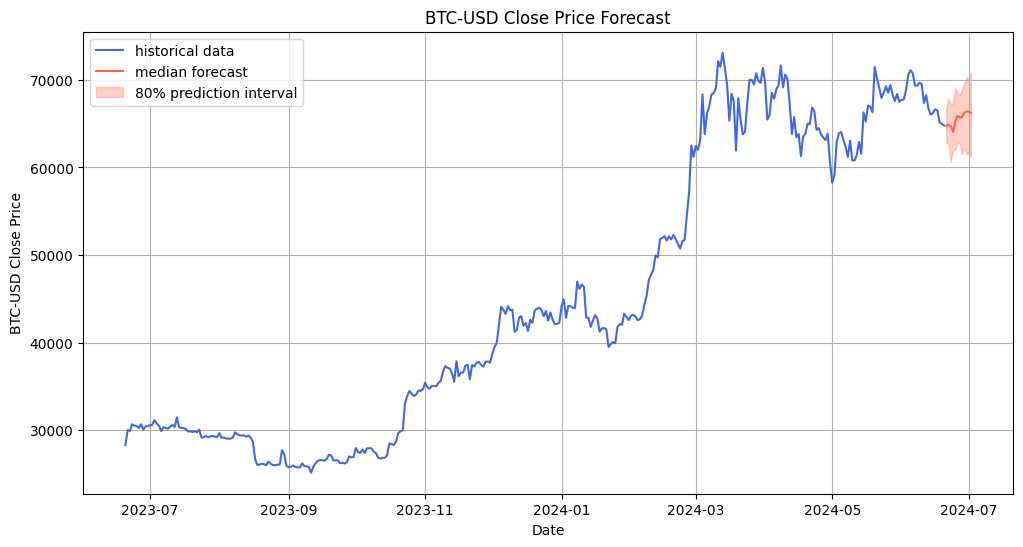

In [8]:
df_btc = pd.read_csv('/home/jabez/Documents/week_9/Crypto-Trading-Engineering/data/BTC-USD.csv')
context_btc = forecast.data_preparation(df_btc)
forecast_btc_date = forecast.generate_forecast_date(df_btc)
forecast.predict(df_btc,forecast_btc_date,context_btc)

/home/jabez/Documents/week_9/Crypto-Trading-Engineering/env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Forecast Dates Range: 2024-06-21 00:00:00 to 2024-07-02 00:00:00
Forecast Values (Median): [586.8961792  581.70239258 580.40396118 576.50860596 577.80706787
 575.21017456 568.71795654 570.01641846 580.40396118 590.79147339
 589.49304199 586.8961792 ]
Forecast Values (Low 10% Quantile): [568.19858398 564.04358521 558.33041992 544.56694336 546.90411987
 546.90411987 552.61727905 545.08631592 541.97001953 550.28008423
 549.24133301 545.86539612]
Forecast Values (High 90% Quantile): [605.8534668  602.73717041 606.11312256 608.96970825 600.3999939
 608.19066162 610.00845947 610.00845947 634.93852539 627.66724854
 635.97727661 644.80671387]


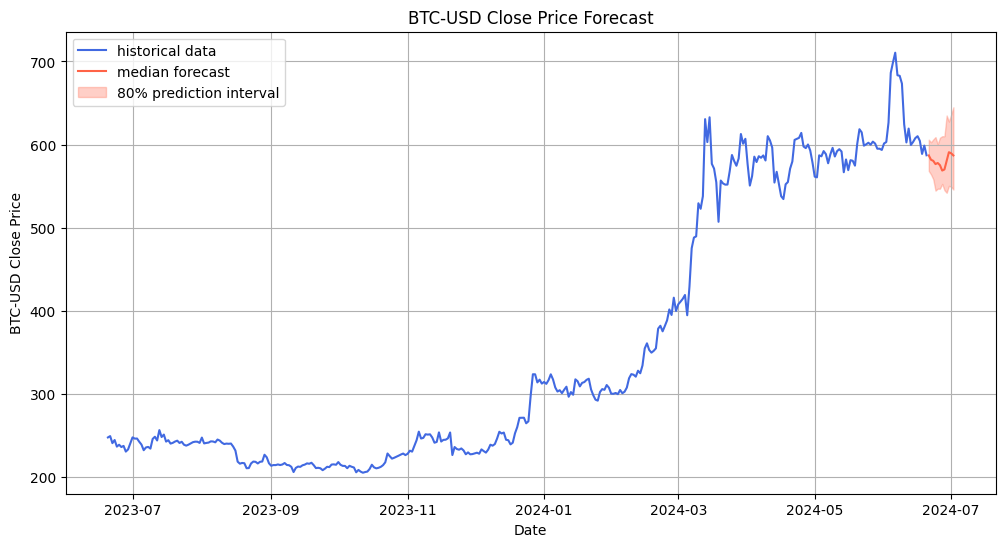

In [5]:
df_bnb = pd.read_csv('/home/jabez/Documents/week_9/Crypto-Trading-Engineering/data/BNB-USD (1).csv')
context_bnb = forecast.data_preparation(df_bnb)
forecast_bnb_date = forecast.generate_forecast_date(df_bnb)
forecast.predict(df_bnb,forecast_bnb_date,context_bnb)

/home/jabez/Documents/week_9/Crypto-Trading-Engineering/env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Forecast Dates Range: 2024-06-21 00:00:00 to 2024-07-02 00:00:00
Forecast Values (Median): [3496.17504883 3514.19677734 3496.17504883 3487.16430664 3496.1751709
 3478.15356445 3451.12133789 3469.14282227 3442.1105957  3442.11047363
 3424.08898926 3424.08898926]
Forecast Values (Low 10% Quantile): [3402.46308594 3460.13208008 3386.24375    3314.1578125  3341.19003906
 3256.4890625  3274.51054687 3206.02885742 3197.01811523 3234.86323242
 3252.8847168  3200.62241211]
Forecast Values (High 90% Quantile): [3568.26123047 3553.84404297 3591.68918457 3571.86555176 3607.90874023
 3624.12807617 3643.95170898 3658.36889648 3665.57749023 3786.32143555
 3762.89355469 3779.11289063]


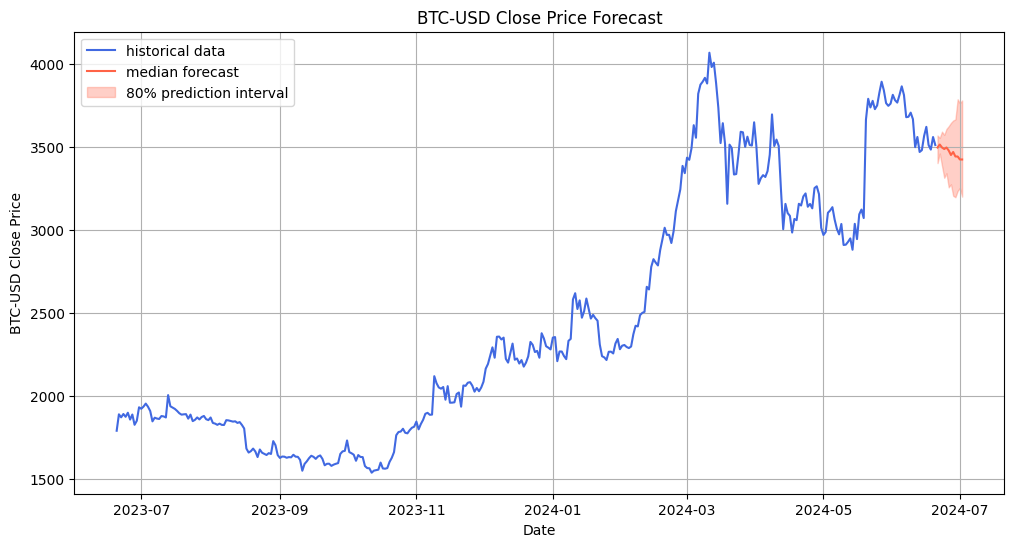

In [7]:
df_eth = pd.read_csv('/home/jabez/Documents/week_9/Crypto-Trading-Engineering/data/ETH-USD.csv')
context_eth = forecast.data_preparation(df_eth)
forecast_eth_date = forecast.generate_forecast_date(df_eth)
forecast.predict(df_eth,forecast_eth_date,context_eth)

/home/jabez/Documents/week_9/Crypto-Trading-Engineering/env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Forecast Dates Range: 2024-06-21 00:00:00 to 2024-07-02 00:00:00
Forecast Values (Median): [132.97674561 132.35536194 132.35536194 131.73397827 130.18050385
 129.86981201 129.55912018 131.73397827 130.49119568 131.42327881
 128.0056572  130.18050385]
Forecast Values (Low 10% Quantile): [129.80767365 126.88716049 126.01721725 123.03456116 122.41317444
 118.31202087 115.82647858 111.22821808 111.72532501 108.30769043
 106.13284149 111.16607666]
Forecast Values (High 90% Quantile): [138.69350586 137.63713989 141.17904205 141.92471771 147.89002991
 146.70938721 144.9073761  147.02007904 146.15014496 145.90159302
 148.13858795 148.94638519]


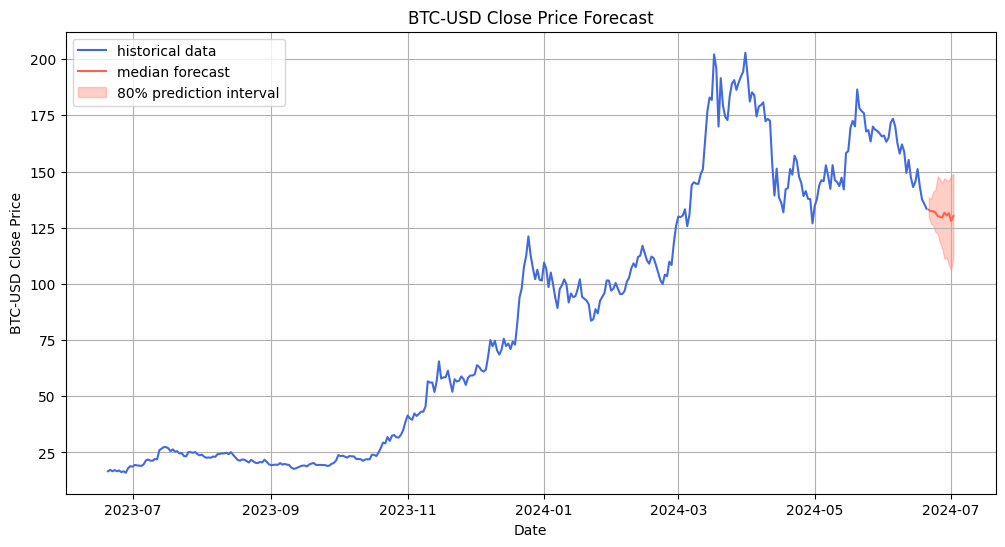

In [9]:
df_sol = pd.read_csv('/home/jabez/Documents/week_9/Crypto-Trading-Engineering/data/SOL-USD.csv')
context_sol = forecast.data_preparation(df_sol)
forecast_sol_date = forecast.generate_forecast_date(df_sol)
forecast.predict(df_sol,forecast_sol_date,context_sol)

/home/jabez/Documents/week_9/Crypto-Trading-Engineering/env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Forecast Dates Range: 2024-06-21 00:00:00 to 2024-07-02 00:00:00
Forecast Values (Median): [0.49022773 0.49022773 0.48815049 0.48607326 0.48815049 0.49438219
 0.49022773 0.49230495 0.49022773 0.48607326 0.49645941 0.49438217]
Forecast Values (Low 10% Quantile): [0.48150333 0.46530089 0.46903989 0.46073097 0.45657649 0.45699194
 0.4557456  0.45283747 0.45657649 0.46031552 0.45657649 0.45491471]
Forecast Values (High 90% Quantile): [0.49853665 0.49479762 0.5031066  0.50269115 0.5072611  0.51515454
 0.5110001  0.51556999 0.51141554 0.51556999 0.51224644 0.51930904]


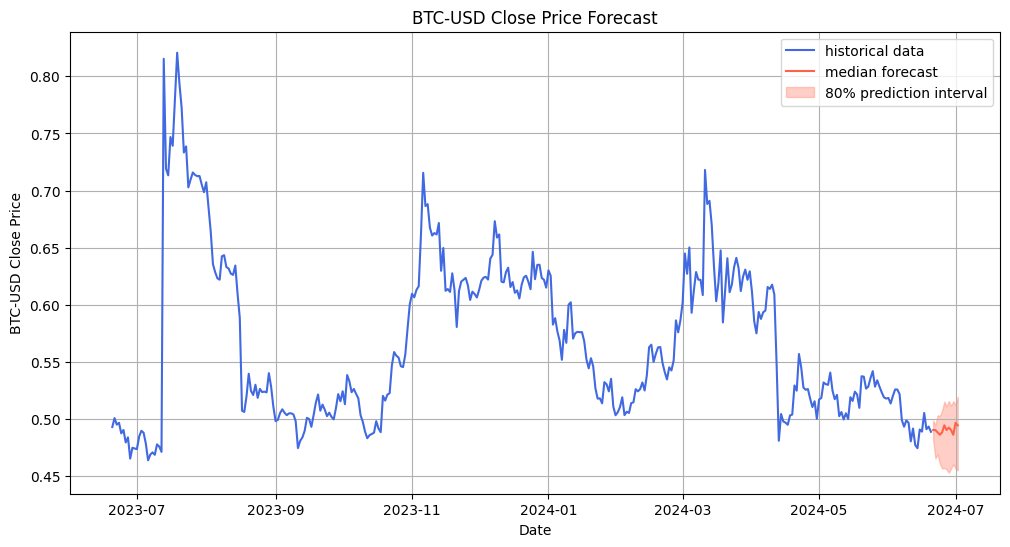

In [10]:
df_xrp = pd.read_csv('/home/jabez/Documents/week_9/Crypto-Trading-Engineering/data/XRP-USD.csv')
context_xrp = forecast.data_preparation(df_xrp)
forecast_xrp_date = forecast.generate_forecast_date(df_xrp)
forecast.predict(df_xrp,forecast_xrp_date,context_xrp)